# Veress Classification

## Grad-CAM class activation visualization

Grad-CAM is used to visual certain areas of an image which are most like the predicted class (fat, muscle, abdominal space, or intestine). An activation heatmap is generated from the predicted class for the supplied image. Then, the original image is superimposed on the class activation heatmap. 

The strongly activated areas in the Grad-CAM image tell us **WHY** the network believed that the image belongs to the predicted class (i.e. layer). The strong activated areas also tell us **WHERE** the predicted class is located in the image. 

- References:
    - [Keras](https://keras.io/examples/vision/grad_cam/)
    - Francois Chollet - Deep Learning with Python (2017, Manning Publications)

### define image to use for Grad-CAM

In [1]:
choose_subject = 1 # range [1, 8]
choose_layer = "fat" # choices ["fat", "muscle", "_abdominal_space"]
choose_idx = 25 # range [1, 1000]

In [2]:
#my_img_filename = "%d_V%d%s.png"%(choose_idx, choose_subject, choose_layer)
mylayer =          "Abdominal Space"
my_img_filename = "993_V1_abdominal_space.png"
#my_img_filename =  "Example2_abdominal_space.png"
#F =                "Example2_abdominal_space"
my_img_vid = 1

my_img_path = "/home/jreynolds/projects/veress/classification/data/GradCam_20211006/raw_images/"+my_img_filename
export_img_filename =       "heatmap_"+my_img_filename+".jpg"
export_img_filename_title = "heatmap_"+my_img_filename+"_title.jpg"

print("image: %s"%my_img_filename)

image: 993_V1_abdominal_space.png


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg

# configure GPUs for tf
print("tf version", tf.version.VERSION)
my_gpu=0
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict tf one GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[my_gpu], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Get the layer (str) from the filename
def GetLayerFromFilename(my_filename):
    # regex out the layer name
    re_layer = re.search('(?<=V\d)\w+', my_filename)
    my_layer = re_layer.group(0)
    # Edge case for abdominal space images with extra underscore between
    # subject ID and layer name in the filename. 
    if my_layer[0]=='_':
        my_layer=my_layer[1:]
    return my_layer

# Get the image index (int) from the filename
def GetImgIdxFromFilename(my_filename):
    # regex out the image index
    re_img_idx = re.search('[0-9]+', my_filename)
    img_idx=int(re_img_idx.group(0))
    return img_idx

def GetSubjectNumberFromFilename(my_filename):
    # regex out the subject ID
    re_vid = re.search('(?<=V)\d', my_filename)
    return int(re_vid.group(0))
    
# A function to generate the path to an image (given the existing file structure of images from Chen)
def GetPath2ImageFromFilename(my_filename):
    img_root_path="/home/jreynolds/projects/veress/classification/data/images/raw_images/"
    img_idx = GetImgIdxFromFilename(my_filename)
    my_layer = GetLayerFromFilename(my_filename)
    S = GetSubjectNumberFromFilename(my_filename)
    # Edge case for abdominal space directories with a capital 'A' in Abdominal_space
    if my_layer == "abdominal_space":
        my_dir="V%d/V%d_%s/%s"%(S, S, my_layer.capitalize(), my_filename)
    else:
        my_dir="V%d/V%d_%s/%s"%(S, S, my_layer, my_filename)
    img_path = img_root_path+my_dir
    return img_path
       
# the model used for cross-training in each testing fold, determined by cross-testing results
arch_winner_dict = {
    1: "Xception",
    2: "Xception",
    3: "Xception",
    4: "InceptionV3",
    5: "Xception",
    6: "Xception", 
    7: "Xception",
    8: "Xception"
}

# mappings used for classification labels
layers_dict = {0: "fat", 1: "muscle", 2: "abdominal space", 3: "intestine"}

tf version 2.5.0
2 Physical GPUs, 1 Logical GPU


### get path info and display image

/home/jreynolds/projects/veress/classification/data/GradCam_20211006/raw_images/993_V1_abdominal_space.png
Path to testing image: /home/jreynolds/projects/veress/classification/data/GradCam_20211006/raw_images/993_V1_abdominal_space.png

Path to model: /home/jreynolds/projects/veress/classification/data/v20210817/CT_results/ct_Model_S1_Xception

 993_V1_abdominal_space.png


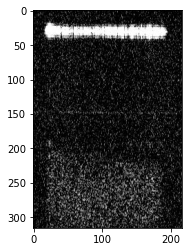

In [4]:
#my_img_vid = GetSubjectNumberFromFilename(my_img_filename)
#my_img_path = GetPath2ImageFromFilename(my_img_filename)
print(my_img_path)
I = mpimg.imread(my_img_path, format="png")

path2modelroot="/home/jreynolds/projects/veress/classification/data/v20210817/CT_results/"
fn_model="ct_Model_S%d_%s"%(my_img_vid, arch_winner_dict[my_img_vid])
path2model=path2modelroot+fn_model

print("Path to testing image:", my_img_path)
print("\nPath to model:", path2model)
print("\n", my_img_filename)
imgplot=plt.imshow(I)
#plt.colorbar()

### load model, clean image, make prediction on model with cleaned image, store highest class prediction for Grad-CAM

In [5]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
K.clear_session()
model_preds = keras.models.load_model(path2model)

img_for_pred=I[:,:,0][np.newaxis, ..., np.newaxis]
raw_pred=model_preds.predict(img_for_pred)
pred=np.argmax(raw_pred)

print("\n\n")
print("%s prediction on %s is %s (%d)"%(fn_model, my_img_filename, layers_dict[pred], pred))

Instructions for updating:
Colocations handled automatically by placer.


/home/jreynolds/anaconda3/envs/tf-gpu9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '





ct_Model_S1_Xception prediction on 993_V1_abdominal_space.png is abdominal space (2)


### reload model for Grad-CAM

In [6]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
K.clear_session()
model = keras.models.load_model(path2model)

### Display model summary to see the name of the model's last convolutional layer

Insert the LAYER_NAME (str) into the argument of the function get_layer in the following code cell.

> **last_conv_layer = model.get_layer(LAYER_NAME)**

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 316, 216, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 157, 107, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 157, 107, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 157, 107, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Generate and display heatmap  

993_V1_abdominal_space.png


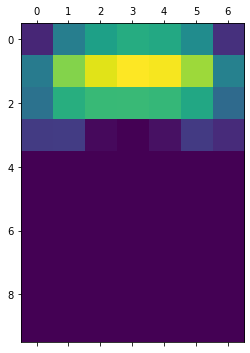

In [8]:
model_output = model.output[:, pred]
#last_conv_layer = model.get_layer("conv2d_93") # InceptionV3
last_conv_layer = model.get_layer("block14_sepconv2_act") # Xception
grads=K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

#I_path = GetPath2ImageFromFilename(filenames_test[arb])
#I = mpimg.imread(my_img_path, format="png")
procd_image = I[:,:,0][np.newaxis, ..., np.newaxis]

pooled_grads_value, conv_layer_output_value = iterate([procd_image])
#L=GetLayerFromFilename(my_img_filename)

for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

print(my_img_filename)
plt.matshow(heatmap)

# Generate and save Grad-CAM

Note: There should be a directory named "export_GradCAM_figs" in the working directory of this notebook serving as the output directory for the Grad-CAM image (.jpg)

In [9]:
import cv2
# load the original img
img=cv2.imread(my_img_path)
# resize heatmap to the same size as the img
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# Apply heatmap to original img
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
fnoext=re.search(r"^[^.]*", my_img_filename)
print(fnoext.group(0))
export_path="/home/jreynolds/projects/veress/classification/data/GradCam_20211006/heatmap_images/"+export_img_filename
cv2.imwrite(export_path, superimposed_img)
#cv2.imwrite('export_GradCAM_figs/V%d_GradCAM_%s.jpg'%(my_img_vid, fnoext.group(0)), superimposed_img)

993_V1_abdominal_space


True

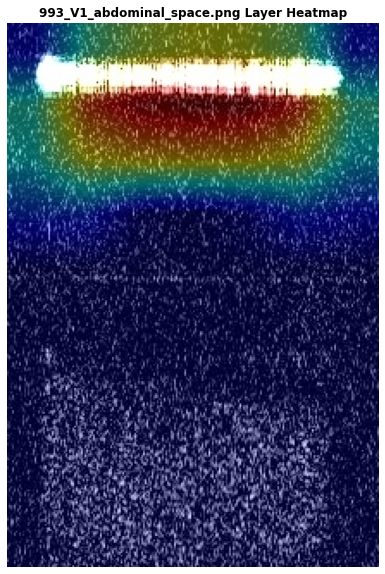

In [10]:
img = cv2.imread(export_path)
#img2 = img[:,:,::-1]
img2 = img[:,:,::-1]
fig,ax=plt.subplots(figsize=(10,10))
ax.set_title("%s Layer Heatmap"%(my_img_filename), fontweight='bold')
ax.set_axis_off()

#ax.text(0.95, 0.01, 'pred=%.2f µm, actual=%.2f µm'%(raw_pred[0][0], MasterDict[img_filename][3]), style='italic',
#        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes,
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
export_path2="/home/jreynolds/projects/veress/classification/data/GradCam_20211006/heatmap_images/"+export_img_filename_title
ax.imshow(img2)
fig.savefig(export_path2, bbox_inches="tight")